# Animal clustering using computer vision

The purpose of this clustering is to ID different animals to support feed measurement. We collected 904 images from the cameras above the feed bunks and cropped the small regions of interets as our first dataset (DS1). This is not the only way. We can also use the fully animal body using MaskRCNN. You will see in the following experiements that the animals put their heads down to feed, making it difficult to see their features. 

The following is the general steps:
1. Collect images to be clustered.
2. Modify a pre-trained ResNet model to extract the feature (2048x1) from the last layer.
3. Apply the modified ResNet on each image to form a matrix (904x2048) where each row is one sample and feature vector is the column values.
4. Use k-means, DBscan, and GMM methods to cluster and visualize.

Workflow for this project:
 - get images from videos
 - train k-means or DBSCAN algo to create two clusters (hopefully "with cow" and "without cow"; will need to manually inspect this)
 - for images w/o cows - keep in order, keep a timestamp of some kind associated as well
 - use images w/o cows to predict feed heights

In [1]:
import os
import numpy as np
from random import randint
import pickle
# import seaborn as sns
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# clustering and dimension reduction
from sklearn.cluster import KMeans, DBSCAN
import re
import datetime

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import cv2
import torch
from torchvision import models, transforms

## New way to get all images (with timestamp in their names)

In [2]:
def get_times_from_filenames(filename: str, date_: str) -> tuple:
    """Create datetime objects for the beginning and end timestamps of a video.
    
    Params
    filename -- should have a substring that identifies it followed by two substrings that contain times of day (formatted HHMMSS), separated by hyphens
    date -- the date that the video was filmed on, formatted as %Y-%m-%d (YYYY-MM-DD)
    
    Returns
    tuple of length 2; each element has a date + time together in a datetime object
    """

    ### TODO -- verify inputs, make sure that date and filename are appropriately formatted
    if bool(re.match('\d{4}-\d{2}-\d{2}', date_)) & bool(re.match('.*-\d{6}-\d{6}', filet)):
        split_name = re.split('-', filename)
        first = date_ + ' ' + split_name[1]
        second = date_ + ' ' + split_name[2][0:6]
        first_dt = datetime.datetime.strptime(first, '%Y-%m-%d %H%M%S')
        second_dt = datetime.datetime.strptime(second, '%Y-%m-%d %H%M%S')
    else:
        raise ValueError('Either the filename or the date supplied was not formatted correctly. please check the inputs to make sure they conform to the accepted format in the docstring.')
        
    return (first_dt, second_dt)


def time_adder(datetime_object: datetime.datetime, every_n_frames: float, fps=30):
    """Add n seconds to a datetime object. 
    
    Params:
    datetime_object -- some datetime object ofc
    every_n_frames -- every nth frame you want to capture
    fps -- frames per second of the video you're working with; should basically always be 30
    
    Returns:
    datetime_object -- the original datetime object with (every_n_frames / fps) seconds added to it
    
    !!! ONLY USE FOR WORKING WITH n_seconds >= 1 (i.e., only when getting 1 frame per second or a slower rate) !!!
    """
    n_seconds = every_n_frames / fps
    if n_seconds >= 1:
        datetime_object += datetime.timedelta(seconds=n_seconds)
        return datetime_object
    else:
        raise ValueError('This function should not be used with (every_n_seconds / fps) < 1 due to rounding errors')
        

In [3]:
failed_iterations = {}
unique_frame_counter = 0
# video_source_folder = '20230920_videos/20230920-Dataset Bunk 3 videos'
video_source_folder = 'sandbox/videos_to_process'
crop_regions = [(180, 1, 450, 400)]  # use to crop out the feed bins; good for bin no. 3

nth_frame = 120  # CHANGE THIS TO ADJUST THE FREQUENCY OF THE IMAGE CAPTURE

list_of_video_files = os.listdir(video_source_folder)
list_of_video_files.sort()
# output_image_folder = 'frames_from_videos/gt_frames_new_new'  # delete this line when you're done w testing the new timestamps one
output_image_folder = 'sandbox/standard_images'
date = '2023-08-22'

In [8]:
for filet in list_of_video_files:   # The directory where we want to run
    if '.mp4' in filet:                                                              #checking for video file and printing name            )
        
        print(filet)
        frame_number=0  # start the frames over at zero
        file_path = os.path.join(video_source_folder, filet)
        
        # get all the video stuff set up
        video_capture = cv2.VideoCapture(file_path)
        w = int(video_capture.get(3))  # width
        h = int(video_capture.get(4))  # height
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        fps = int(video_capture.get(cv2.CAP_PROP_FPS))        

        # keep track of the timestamps
        timestamp1, timestamp2 = get_times_from_filenames(filet, date)
        # skip to the next filet in list_of_video_files if timestamp1 exceeds timestamp2 (o sea if the next frame is not in the video)
        
        # loop through the video and get every nth frame
        while True:
            ret, frame = video_capture.read()  # frame shape 640*480*3 - not sure if this is relevant anymore
            # make sure that the video capture worked correctly
            if ret != True:
                break
                
            if frame_number % nth_frame != 0:  # check if it's one of every n frames
                frame_number += 1  # increment if it is not one of the nth frames
                continue  # skip the file cropping/saving if modulo(frame_num, nth_frame) != 0 and continue on to the next iteration without doing anything else

            # if the frame *is* one of the nth frames, do the following
            for idx, crop_region in enumerate(crop_regions):
                x, y, w, h = crop_region
                try:
                    cropped_frame = frame[y:y + h, x:x + w]  # crop the frame
                    img = np.uint8(cropped_frame)  # convert to np array
                    timestamp1_as_string = re.sub('[^A-Za-z0-9]', '_', str(timestamp1))
                    cv2.imwrite(f'{output_image_folder}/img_{timestamp1_as_string}.png', img)  # write to folder  # uncomment this when ready; make sure to format the name right
                    # print(f'image_{timestamp1_as_string}.png')
                except TypeError as te:
                    print(f'frame number {frame_number} was not cropped')  # if the image can't be cropped or written alert the user
                    failed_iterations[filet] = frame_number
                except BaseException as b:  # update with a more specific error lol
                    failed_iterations[filet] = frame_number
                    print(f'something went wrong while trying to crop or write image_{unique_frame_counter}: {b} ({type(b)})')

            timestamp1 = time_adder(timestamp1, nth_frame, fps=fps)  # plays the same role as unique_frame_counter
            if timestamp1 > timestamp2:
                break
            # unique_frame_counter += 1  # update the image name counter after either successfully writing an image or catching an error
            frame_number += 1  # even though you're using the timestamp to label images, keep this in so that you can make sure you're getting every nth frame without issues.

            if (frame_number - 1) % 150 == 0:
                print(f'Frame number {frame_number - 1} ({timestamp1}) was just processed.')
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cv2.destroyAllWindows()

NVRCH03-103225-103725-Copy1.mp4
Frame number 0 (2023-08-22 10:32:29) was just processed.
Frame number 600 (2023-08-22 10:32:49) was just processed.
Frame number 1200 (2023-08-22 10:33:09) was just processed.
Frame number 1800 (2023-08-22 10:33:29) was just processed.
Frame number 2400 (2023-08-22 10:33:49) was just processed.
Frame number 3000 (2023-08-22 10:34:09) was just processed.
Frame number 3600 (2023-08-22 10:34:29) was just processed.
Frame number 4200 (2023-08-22 10:34:49) was just processed.
Frame number 4800 (2023-08-22 10:35:09) was just processed.
Frame number 5400 (2023-08-22 10:35:29) was just processed.
Frame number 6000 (2023-08-22 10:35:49) was just processed.
Frame number 6600 (2023-08-22 10:36:09) was just processed.
Frame number 7200 (2023-08-22 10:36:29) was just processed.
Frame number 7800 (2023-08-22 10:36:49) was just processed.
Frame number 8400 (2023-08-22 10:37:09) was just processed.
NVRCH03-104225-104725.mp4
Frame number 0 (2023-08-22 10:42:29) was just 

# Get a list of all the images

In [4]:
# this is for comparing with the ground truth images
# gt_unlabeled_path = 'frames_from_videos/gt_frames/gt_all_unlabeled'  # calla is the bestttttttt 4evr  # use this normally
gt_unlabeled_path = 'frames_from_videos/gt_frames_with_timestamp/all_gt'

image_list = os.listdir(gt_unlabeled_path)  # Replace with the path to your directory
image_list.sort()

images=[]
# Print the list of files
for file in image_list:
    # file_path = file
    file_path=os.path.join(gt_unlabeled_path, file)
    image=cv2.imread(file_path)  # this used to have [0] at the end but the dimensions were getting all messed up with that
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
image_data_ = np.array(images)
# len(os.listdir(directory_path))

In [5]:
experimental = pd.DataFrame({'img_label':image_list, 'image_array':images})

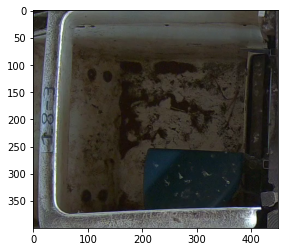

In [6]:
plt.imshow(image_data_[500])

# Resnet classification

Resnet pre-trained on ImageNet dataset with 1000 classes hence the pridiction shape is 1000 dimensional.

In [7]:
# Load a pre-trained ResNet model (e.g., ResNet-50)
resnet = models.resnet50(pretrained=True)

resnet.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    # TODO -- try running this without transforms.Normalize commented out (but verify that this is valid by inspecting images)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # keep this uncommented ://
    # transforms.ToPILImage()
])

In [8]:
# this transform here is from the video_labeling.ipynb notebook. It might need some love before it's ready to go

# # this is the mean and standard deviation for imagenet dataset
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])
# # class_names = ['S00','S05','S10','S20','S30','S40']

# np.random.seed(50)  # new
# transform_ = transforms.Compose([
# #         transforms.RandomResizedCrop(224),
#         transforms.Resize((224,224)),
# #         transforms.CenterCrop((224,224)),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         # transforms.Normalize(mean, std)
#     ])

In [9]:
# image = transform(Image.fromarray(image))
# image_ = image.unsqueeze(0)  # Add a batch dimension (required by the model)
# # Forward pass to extract features
# with torch.no_grad():
#     out = resnet(image_)
# out.shape

# Load 1000 class names from Github

This is a long list. You can check it out.

In [10]:
import requests
master = "https://gist.githubusercontent.com/TAMIDSpiyalong/69d949157e90dcee1d8e730b74887931/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
req = requests.get(master)
idx2label  = eval(req.text)
# for idx in out[0].sort()[1][-10:]:
#     print(idx2label[int(idx)],   idx, out[0][idx])

In [11]:
# sortedProba = torch.argsort(out, dim=-1, descending=True)
# for idx in sortedProba[0][:10]:
#     print(idx2label[int(idx)],   idx, out[0][idx])

In [12]:
# sortedProba.shape

# Resnet as feature extractor

In [13]:
# torch.nn.Sequential(*list(resnet.children())[:5])  # experimenting with what layer to take the output from

In [14]:
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

# output = feature_extractor(image_) # output now has the features corresponding to input x
# print(output.shape)

Here we are using only the layer before the last output layer, i.e., 1000 dimensional output corresponding to each class.

In [15]:
# this is the default one, but use the one below rn

# features=[]
# for file in os.listdir(directory_path) :
#     file_path=(os.path.join(directory_path, file))
#     image=cv2.imread(file_path)
#     # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = transform(Image.fromarray(image))
#     image = image.unsqueeze(0)  # Add a batch dimension (required by the model)
#     feature = feature_extractor(image) # output now has the features corresponding to input x
#     features.append(feature.detach().numpy()[0][:][:])
#     # break

In [16]:
# features=[]
# for file in image_list:
#     file_path=(os.path.join(gt_unlabeled_path, file))
#     image=cv2.imread(file_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image_ = transform(Image.fromarray(image))
#     image = image_.unsqueeze(0)  # Add a batch dimension (required by the model)
#     feature = feature_extractor(image) # output now has the features corresponding to input x
#     features.append(feature.detach().numpy()[0][:][:])
#     # break

# let's update this so it actually uses the gpu :)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
feature_extractor.to(device)

features=[]
for file in image_list:
    file_path=(os.path.join(gt_unlabeled_path, file))
    image=cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_ = transform(Image.fromarray(image))
    image = image_.unsqueeze(0)  # Add a batch dimension (required by the model)
    image = image.to(device)
    feature = feature_extractor(image) # output now has the features corresponding to input x
    features.append(feature.detach().cpu().numpy()[0][:][:])
    # break

/scratch/user/jwooley/jackvenv/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


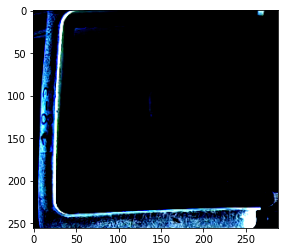

In [17]:
plt.imshow(image_.cpu().numpy().transpose(1, 2, 0))

In [18]:
len(features)

600

In [19]:
np.array(features).shape

(600, 2048, 1, 1)

In [20]:
np.array(features)[:,:,0,0].shape

(600, 2048)

## t-SNE
We get 904 images therefore a 904x2048 dimensional vector representing all images. Now we use T-SNE to look at the images in a 2D space. Here the similar images will appear closer to each other. 

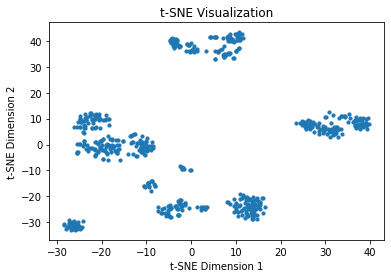

In [21]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Generate or load your data, assuming it's a (904, 2048) numpy array
# Replace this with your actual data loading or generation logic
data = np.array(features)[:,:,0,0]

# Initialize t-SNE with the desired number of components (2 for 2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform your data to reduce it to 2 dimensions
tsne_result = tsne.fit_transform(data)

# Create a scatter plot to visualize the t-SNE results
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10)  # s controls point size
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()


In [22]:
tsne_result.shape

(600, 2)

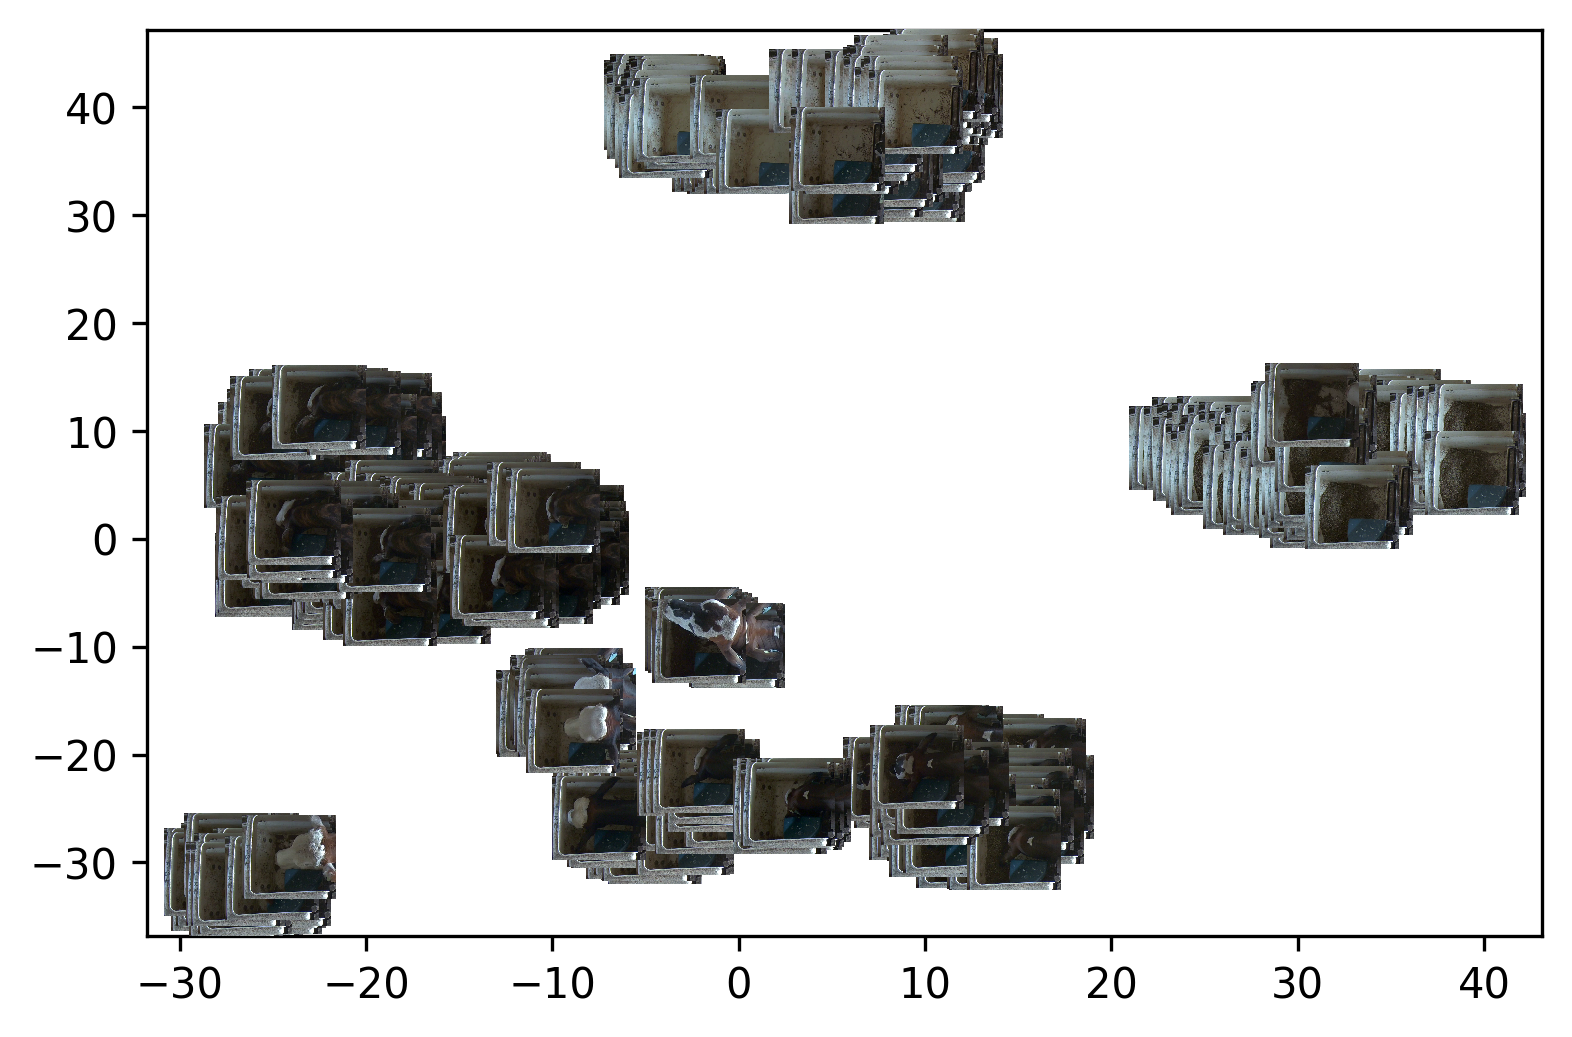

In [23]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig, ax = plt.subplots(dpi=300)

ax.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10)  # s controls point size

for i in range(len(images)):
    imagebox = OffsetImage(images[i], zoom=0.05)  # Adjust the zoom factor as needed
    ab = AnnotationBbox(imagebox, tsne_result[i], frameon=False, pad=0)
    ax.add_artist(ab)

# K-means

k-means methos requires us to define the cluster number. We do not know how many animals are inside in advance.

But in this case, we know there are three types by looking at them:
* with animal
* empty
* full

We are going to do 2 clusters to hopefully end up with "with cow" and "without cow" clusters

In [24]:
from typing import Union
def fit_and_evaluate(list_of_k: list, data_to_fit_predict: Union[np.ndarray, pd.DataFrame], nrows=10):
    k_means_clusters = list_of_k  # 10 clusters looks like it gets a lot of highly specialized clusters; 
    sse_ = {}  # track performance
    all_kmeans = {}  # all fitted kmeans models to use later
    plot_nrows = nrows  # the number of images to sample from each class
    for k in k_means_clusters:
        # Define the number of clusters (K)
        num_clusters = k

        # Perform K-means clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data_to_fit_predict)

        # Create subplots to display images from each cluster
        # upper_bound = int(.75 * tsne_result.shape[0] // num_clusters)  # specify a size that will hopefully not exceed the size of the cluster sets
        # random_indices = np.random.randint(low=0, high=upper_bound, size=10)
        fig, axes = plt.subplots(plot_nrows, num_clusters, figsize=(15, 2.5*nrows))

        # for i in range(len(random_indices)):  # print out 10 random images
        for i in range(plot_nrows):
            for cluster_id in range(num_clusters):
                # cluster_images = image_data[cluster_labels == cluster_id]
                cluster_images = image_data_[cluster_labels == cluster_id]
                upper_bound = len(cluster_images) - 1
                image_subset = np.random.randint(low=0, high=upper_bound, size=plot_nrows)
                # Choose a representative image from the cluster
                sample_image = cluster_images[image_subset[i]]

                # Display the sample image
                axes[i][cluster_id].imshow(sample_image)
                axes[i][cluster_id].set_title(f'Cluster {cluster_id}')

        for ax in axes:
            for j in ax:
                j.axis('off')

        # evaluate performance
        sse_[k] = kmeans.inertia_  # sum of distances of samples to their closest cluster

        plt.suptitle('K-means Clustering Results')
        plt.show()

        # input()  # use this to control the speed of iteration - it won't move to the next one until you've visually inspected the output and it
        
        all_kmeans[k] = kmeans
        
    return all_kmeans, sse_

2 and 3 clusters aren't enough, 4 is close but struggles with some darker images and images with dark cows like w/o spots (###TODO -- TRY ADDING THE ADJUST_BRIGHTNESS SEGMENT TO THE PIPELINE), 5 is like 4 but looks kinda overfit/worse, and 10 looks pretty good - it has a lot of clusters but they seem to be nicely separated

In [21]:
kmeans_, _= fit_and_evaluate([2], tsne_result)

NameError: name 'tsne_result' is not defined

In [215]:
kmeans_[15].labels_.shape

KeyError: 15

In [ ]:
has_a_cow = []
no_cow = []
cow_lab = []

# do an inefficient matching check
for i in range(len(kmeans_[15].labels_)):
    for tru in np.array([0, 1, 3, 4, 7, 9]):  # look at clusters with cows
    # for tru in np.array([1, 2, 5, 6, 7, 8, 11, 12, 14]):
    # for tru in np.array([0, 1, 2, 4, 7]):
        if kmeans_[15].labels_[i] == tru:
            has_a_cow.append(i)
            cow_lab.append(1)

    for fals in np.array([2, 5, 6, 8]):  # look at clusters without cows
    # for fals in np.array([0, 3, 4, 9, 10, 13]):
    # for fals in np.array([3, 5, 6]):
        if kmeans_[15].labels_[i] == fals:
            no_cow.append(i)
            cow_lab.append(0)

KeyError: 15

In [22]:
# plot the clusters w cluster_ids as colors
u_labels = np.unique(kmeans_[10].labels_)
u_labels_ = np.unique(cow_lab)
centroids = kmeans_[10].cluster_centers_

# all non-cow ones

fig, ax = plt.subplots(figsize=(12, 12))
#plotting the results:
for i in u_labels:
    # for j in u_labels_:
    if i in [0, 1, 3, 4, 7, 9]:
    # if i in [1, 2, 5, 6, 7, 8, 11, 12, 14]:
        ax.scatter(tsne_result[kmeans_[10].labels_ == i, 0] , tsne_result[kmeans_[10].labels_ == i, 1] , label='cow present', c='green')
    if i in [2, 5, 6, 8]:
    # if i in [0, 3, 4, 9, 10, 13]:
        ax.scatter(tsne_result[kmeans_[10].labels_ == i, 0] , tsne_result[kmeans_[10].labels_ == i, 1] , label='no cow present', c='red')
ax.scatter(centroids[:,0] , centroids[:,1] , s = 500, marker='H', color = 'k', alpha=.6)
ax.set_title('10 Clusters from t-SNE Data')
plt.legend()
# plt.savefig('tsne10clusters.jpg')
plt.show()

KeyError: 10

## Trying that with PCA now
PCA should work better to generalize to out-of-sample data than t-SNE. 

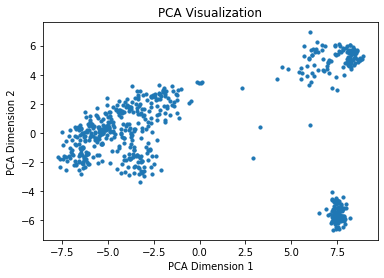

In [25]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Generate or load your data, assuming it's a (603, 2048) numpy array
data = np.array(features)[:,:,0,0]

pca = PCA(n_components=2, random_state=64)

# Fit and transform your data to reduce it to 2 dimensions
pca_result = pca.fit_transform(data)

# Create a scatter plot to visualize the PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=10)  # s controls point size
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('PCA Visualization')
plt.show()


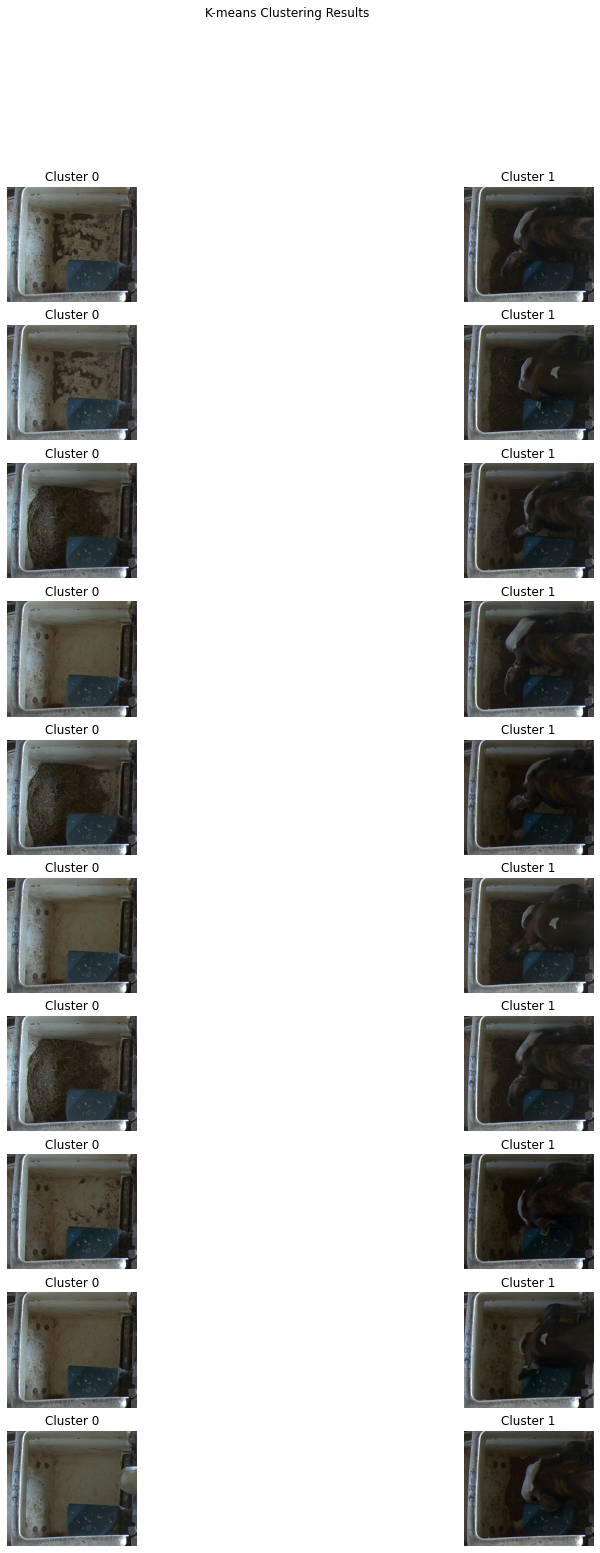

In [26]:
# kmpca, sses = fit_and_evaluate([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], pca_result, 10)
kmpca, _ = fit_and_evaluate([2], pca_result, 10)

This might require you to manually inspect the clusters and update the lines that look like `if kmpca[2].labels_[i] == 1:`

It is set up right now based on the assumption that cluster 1 has cows and cluster 0 has no cows

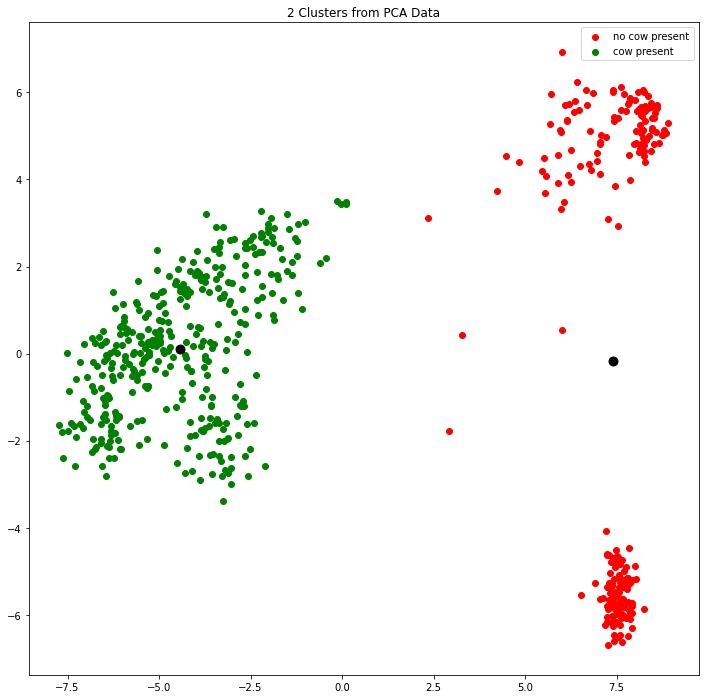

In [27]:
has_a_cow = []
no_cow = []
cow_lab = []

kmeans_labels = kmpca[2].labels_

# do an inefficient matching check
for i in range(len(kmeans_labels)):
    if kmeans_labels[i] == 1:  # if the ith label is == 1,
        has_a_cow.append(i)  # then append index number to the has_a_cow list
        cow_lab.append(1)  # and append a 1 (truthy) to the cow_lab list

    if kmeans_labels[i] == 0:  # if the ith label is == 0
        no_cow.append(i)  # then append the ith index to no_cow
        cow_lab.append(0)  # and append a 0 (falsy) to the cow_lab list
            
# plot the clusters w cluster_ids as colors
u_labels = np.unique(kmeans_labels)
# u_labels_ = np.unique(cow_lab)
centroids = kmpca[2].cluster_centers_

#plotting the results:
fig, ax = plt.subplots(figsize=(12, 12))
for i in u_labels:
    if i == 0:
        ax.scatter(pca_result[kmeans_labels == i, 0] , pca_result[kmeans_labels == i, 1] , label='no cow present', c='red')
    if i == 1:
        ax.scatter(pca_result[kmeans_labels == i, 0] , pca_result[kmeans_labels == i, 1] , label='cow present', c='green')
ax.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
ax.set_title('2 Clusters from PCA Data')
# plt.savefig('pca2clusters.jpg')
plt.show()

## Clustering metrics

In [28]:
from sklearn import metrics
# metrics.rand_score(cow_lab, 

In [29]:
has_a_cow = os.listdir('frames_from_videos/gt_frames_with_timestamp/has_a_cow')
no_cow = os.listdir('frames_from_videos/gt_frames_with_timestamp/no_cow')
hac = []
nc = []
all_ = []
for i in image_list:
    if i in has_a_cow:
        all_.append(1)
    elif i in no_cow:
        nc.append(i)
        all_.append(0)
    elif (i in has_a_cow) and (i in no_cow):
        print(i)
    else:
        print(i)

In [30]:
metrics.adjusted_rand_score(all_, kmeans_labels)

0.9933063759598809

In [31]:
metrics.rand_score(all_, kmeans_labels)

0.9966666666666667

Using this list of all images in the 'has a cow' cluster, we can cluster those images and hopefully do it by cow.

In [32]:
all_images_in_cow_cluster = np.array(image_list)[kmeans_labels == 1]  # get a list of all images in the has a cow cluster

cow_images=[]
# Print the list of files
for cow_file in all_images_in_cow_cluster:
    cow_file_path=os.path.join(gt_unlabeled_path, cow_file)
    cow_image=cv2.imread(cow_file_path)  # this used to have [0] at the end but the dimensions were getting all messed up with that
    cow_image = cv2.cvtColor(cow_image, cv2.COLOR_BGR2RGB)
    cow_images.append(cow_image)
cow_image_data_ = np.array(cow_images)

In [33]:
gt = pd.read_csv('OUT_SENS_EDITED_2023-08-22_OUTPUT_SENSORSEDITED_FULLDAY_SENSORS - 1032 to1127h - OUT_SENS_EDITED_2023-08-22_OUTP.csv')  # read in 'ground truth' csv

import datetime
time_ranges = [(103225,103725),(103725,104225),(104225,104725),(104725,105225),(110227,110727),(110727,111227),(111727,112227),(112227,112727)]

selected_indices = []
error_indices = []
for i in range(len(time_ranges)):
    time0 = datetime.datetime.strptime(f'2023-08-22 {time_ranges[i][0]}', '%Y-%m-%d %H%M%S')
    time1 = datetime.datetime.strptime(f'2023-08-22 {time_ranges[i][1]}', '%Y-%m-%d %H%M%S')
    for j in range(gt.shape[0]):
        try:
            jth_time = datetime.datetime.strptime(f'{gt.DateTime[j]}', '%Y-%m-%d %H:%M:%S')
            if (time0 <= jth_time) & (time1 > jth_time):
                selected_indices.append(j)
        except ValueError as v:
            error_indices.append(j)
            jth_time = datetime.datetime.strptime(f'{gt.Date[j]} {gt.Time[j]}', '%Y-%m-%d %H:%M:%S')
            if (time0 <= jth_time) & (time1 > jth_time):
                selected_indices.append(j)

gt_40_mins = gt.iloc[selected_indices,:]
gt_40_mins.reset_index(inplace=True)

np.unique([str(i) for i in gt_40_mins.FBK_03_ANIMAL])  # will display all the unique animals that were seen at feedbunk 3 during the 40 mins we have data for

array(['AN-02', 'AN-05', 'AN-06', 'nan'], dtype='<U5')

In [34]:
# get the ground truth animal labels for each image in the 'all_images_in_cow_cluster' array
synced_animal_ids = []
for i in all_images_in_cow_cluster:
    no_file_extension = i[4:-4]
    for j in range(gt_40_mins.shape[0]):
        non_alphanum_replaced_w_underscores = re.sub('[^\w]', '_', str(gt_40_mins.DateTime[j]))
        if no_file_extension == non_alphanum_replaced_w_underscores:
            synced_animal_ids.append(gt_40_mins.FBK_03_ANIMAL[j])

In [35]:
cow_features = []
untransformed_images = []
for file in all_images_in_cow_cluster:
    file_path=(os.path.join(gt_unlabeled_path, file))
    image=cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    untransformed_images.append(image)
    image = transform(Image.fromarray(image))
    image = image.unsqueeze(0)  # Add a batch dimension (required by the model)
    image = image.to(device)
    feature = feature_extractor(image) # output now has the features corresponding to input x
    cow_features.append(feature.cpu().detach().numpy()[0][:][:])
    # break
untransformed_images = np.array(untransformed_images)
cow_feature_array = np.array(cow_features)[:,:,0,0]

In [36]:
TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(cow_feature_array)

db = DBSCAN(eps=10, min_samples=2)  # You can adjust 'eps' and 'min_samples' as needed
cluster_labels = db.fit_predict(tsne_result)
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,

In [37]:
# Generate or load your data, assuming it's a (603, 2048) numpy array
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# data_cows = np.array(cow_features)[:,:,0,0]

cow_data = np.array(cow_features)[:,:,0,0]


def kmeans_for_cow_cluster(n_comps: int, n_clusters: Union[int, float], plot_nrows: int = 10, show_plot: bool = False):
    # do kmeans w n_comps components
    pca_ = PCA(n_components=n_comps, random_state=64)

    # Fit and transform your data to reduce it to 2 dimensions
    pca_result_ = pca_.fit_transform(cow_data)
    
    # Perform K-means clustering
    kmeans_ = KMeans(n_clusters=n_clusters, random_state=64)
    # kmeans_ = DBSCAN(eps=n_clusters)  # need to tune eps parameter a lot more  # experimenting with DBSCAN - eps = .65 got the highest metrics.adjusted_rand_score
    cluster_labels_ = kmeans_.fit_predict(pca_result_)

    # Create subplots to display images from each cluster
    # check if you need to plot or not:
    if show_plot:  # defaults to False, accepts a boolean value
        fig, axes = plt.subplots(plot_nrows, n_clusters, figsize=(15, 2.5*plot_nrows))

    # for i in range(len(random_indices)):  # print out 10 random images
        for row in range(plot_nrows):
            for cluster_id in range(n_clusters):
                # cluster_images = image_data[cluster_labels == cluster_id]
                cluster_images_ = cow_image_data_[cluster_labels_ == cluster_id]
                upper_bound_ = len(cluster_images_) - 1
                image_subset_ = np.random.randint(low=0, high=upper_bound_, size=plot_nrows)
                # Choose a representative image from the cluster
                sample_image_ = cluster_images_[image_subset_[row]]

                # Display the sample image
                axes[row][cluster_id].imshow(sample_image_)
                axes[row][cluster_id].set_title(f'Cluster {cluster_id}')

        for ax in axes:
            for j in ax:
                j.axis('off')

        plt.suptitle('K-means Clustering Results')
        plt.show()
    
    return kmeans_, pca_result_

In [38]:
# get only images that are in the cow cluster
img_dates = [i[4:-4] for i in all_images_in_cow_cluster]
animal_id = []
for i in range(gt_40_mins.shape[0]):
    underscore_datetime = re.sub('[^\w]', '_', str(gt_40_mins.Date[i])) + '_' + re.sub('[^\w]', '_', str(gt_40_mins.Time[i]))
    if underscore_datetime in img_dates:
        animal_id.append(gt_40_mins.FBK_03_ANIMAL[i])

unique_combos_dict = {}

# pca_ncomps_list = [1, 2, 3, 4, 5, 6]
pca_ncomps_list = [4]
# kmeans_nclusters_list = [3, 6, 9]
kmeans_nclusters_list = [6]

elbows = []

for n in pca_ncomps_list:
    for km in kmeans_nclusters_list:
        kmcow, pcacow = kmeans_for_cow_cluster(n_comps=n,  # number of components in the pca
                                       n_clusters=km,  # number of clusters in the kmeans
                                       plot_nrows=10  # number of rows to plot
                                      )

        # create df with image names, image dates (img names with 'img_' and file extension stripped, gt animal id, and clustering animal id
        clusters_and_gt = pd.DataFrame({'image_names': all_images_in_cow_cluster, 'img_dates': img_dates, 'animal_id': animal_id, 'kmeans_labs': kmcow.labels_})
        clusters_and_gt_no_na = clusters_and_gt.dropna()  # drop nan values (shouldn't be very many)
        if len(kmcow.labels_) * .9 > clusters_and_gt_no_na.shape[0]:
            print('Warning! More than 10% of the values were dropped when creating the dataframe, which could indicate an issue with the code that matches dates in image names up to dates in gt dataset.')

        unique_combos = {}
        # check how often each combo of unique gt_animal_id/kmeans_labels
        # for i in range(len(clusters_and_gt_no_na.animal_id)):
        #     if (clusters_and_gt_no_na.animal_id.iloc[i], clusters_and_gt_no_na.kmeans_labs.iloc[i]) not in unique_combos.keys():
        #         unique_combos[(clusters_and_gt_no_na.animal_id.iloc[i], clusters_and_gt_no_na.kmeans_labs.iloc[i])] = 1
        #     elif (clusters_and_gt_no_na.animal_id.iloc[i], clusters_and_gt_no_na.kmeans_labs.iloc[i]) in unique_combos.keys():
        #         unique_combos[(clusters_and_gt_no_na.animal_id.iloc[i], clusters_and_gt_no_na.kmeans_labs.iloc[i])] += 1
        
        for i in np.unique(kmcow.labels_):
            ids_from_i = clusters_and_gt.animal_id[kmcow.labels_ == i]
            ids_counts = ids_from_i.value_counts()
            # tuple_ = (i, ids_counts)
            for j in range(len(ids_counts)):
                unique_combos[(i, ids_counts.index.tolist()[j])] = ids_counts.values.tolist()[j]
        
        unique_combos_dict[str(n) + '_' + str(km)] = unique_combos
        
        elbows.append(metrics.adjusted_rand_score(kmcow.labels_, [str(i) for i in clusters_and_gt.animal_id]))

# unique_combos

array(['4_6'], dtype='<U3')

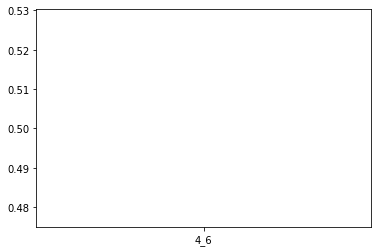

In [39]:
# experimenting with DBSCAN - eps = .65 got the highest metrics.adjusted_rand_score
plt.plot(unique_combos_dict.keys(), elbows)
np.array(list(unique_combos_dict.keys()))[elbows == max(elbows)]

In [40]:
metrics.adjusted_rand_score(kmcow.labels_, [str(i) for i in clusters_and_gt.animal_id])

0.50257057522784

In [41]:
metrics.silhouette_score(kmcow.labels_.reshape(-1, 1), [str(i) for i in clusters_and_gt.animal_id])

0.0196950185369491

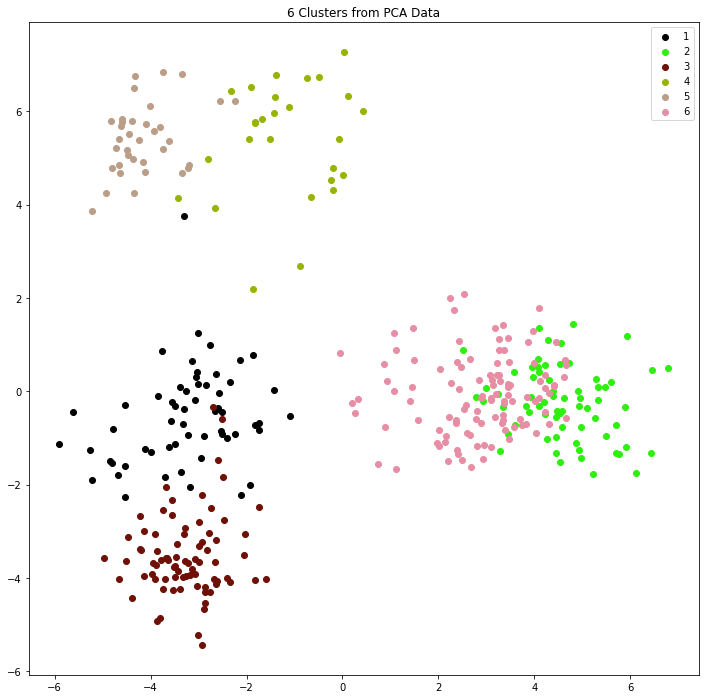

In [42]:
from matplotlib.colors import XKCD_COLORS
xkcd_colors = list(XKCD_COLORS.values())#[19:43]
xkcd_colors.sort()

fig, ax = plt.subplots(figsize=(12, 12))
for i in range(len(np.unique(kmcow.labels_))):
    # if i == 0:
    # print(f'{len(pcacow[kmcow.labels_ == kmcow.labels_[i]])}')
    ax.scatter(pcacow[kmcow.labels_ == np.unique(kmcow.labels_)[i], 0] , pcacow[kmcow.labels_ == np.unique(kmcow.labels_)[i], 1], label=f'{np.unique(kmcow.labels_)[i] + 1}', 
               c=xkcd_colors[i * (len(xkcd_colors) // len(np.unique(kmcow.labels_)))])#np.random.randint(105)])

plt.legend()
ax.set_title(f'{len(np.unique(kmcow.labels_))} Clusters from PCA Data')
plt.show()

## Trying other methods to cluster all the images
1. other clustering things (DBSCAN, kmediods, affinity propagation, spectral clustering)
2. other feature extraction/dimensionality reduction things

#### Trying to get the same level of success as Yalong with t-SNE/DBSCAN

In [43]:
feature_subset = np.array(features)[kmpca[2].labels_ == 1][:,:,0,0]

tt = TSNE(n_components=2, random_state=42)
tt_res = tt.fit_transform(feature_subset)

db_ = DBSCAN(eps=10, min_samples=2)  # You can adjust 'eps' and 'min_samples' as needed
cls_ = db_.fit_predict(tt_res)
cls_

from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(cls_, [str(i) for i in clusters_and_gt.animal_id])

0.9600876943426542

##### It worked! It looks like I basically only had to adjust the eps parameter. Still weird that it happened, but cool that it works now.

## Feed Grading
### Get feed grade scores for images not present in the has_a_cow cluster

In [44]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# np.random.seed(50)  # new
feed_grade_transform = transforms.Compose([
#         transforms.RandomResizedCrop(224),
        transforms.Resize((224,224)),
#         transforms.CenterCrop((224,224)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

class_names = ['S00','S05','S10','S20','S30','S40']
grade_model = models.resnet18(pretrained=False)
num_ftrs = grade_model.fc.in_features
grade_model.fc = torch.nn.Linear(num_ftrs, len(class_names))
grade_model.load_state_dict(torch.load('best_model_used_for_jan_8th_abstract.pth'))
grade_model = grade_model.to(device)

create dataloader to load feed bunk images in

In [45]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class InferenceDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        image = Image.open(self.file_paths[index]).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image

images_to_grade = np.array(image_list)[kmpca[2].labels_ != 1]
full_image_paths = [os.path.join('frames_from_videos/gt_frames_with_timestamp/all_gt', img_path) for img_path in images_to_grade]
inference_dataset = InferenceDataset(full_image_paths, transform=feed_grade_transform)
batch_size = 1
inference_dataloader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

In [46]:
grade_model.eval()

feed_grade_predictions = []

with torch.no_grad():
    for batch in inference_dataloader:
        batch = batch.to(device)
        outputs = grade_model(batch)
        _, predicted_classes = torch.max(outputs, 1)

        feed_grade_predictions.append(class_names[predicted_classes.cpu().numpy()[0]])


In [52]:
check = []
all_images.sort()
for i in range(0, len(has_no_cow)):
    if has_no_cow[i] == all_images[i]:
        check.append(i)

In [68]:
all_images = os.listdir('frames_from_videos/gt_frames_with_timestamp/all_gt')
has_a_cow = all_images_in_cow_cluster
has_no_cow = images_to_grade
cow_id_for_df = []
feed_grade_for_df = []

for i in all_images:
    if i in has_a_cow:
        cow_id_for_df.append(cls_[list(has_a_cow).index(i)])
        feed_grade_for_df.append(np.nan)
    elif i in has_no_cow:
        feed_grade_for_df.append(feed_grade_predictions[list(has_no_cow).index(i)])
        cow_id_for_df.append(np.nan)
#     else:

# for i in range(len(os.listdir('frames_from_videos/gt_frames_with_timestamp/all_gt'))):
#     if all_images[i] in has_a_cow:
#         cow_id_for_df.append(cls_[i])
#         feed_grade_for_df.append(np.nan)
#     elif all_images[i] in has_no_cow:
#         feed_grade_for_df.append(feed_grade_predictions[i])
#         cow_id_for_df.append(np.nan)
#     else:
#         feed_grade_for_df.append(np.nan)
#         cow_id_for_df.append(np.nan)

In [74]:
all_images.sort()

In [100]:
pd.DataFrame({'timestamps': [re.sub('_', '/', img_path[4:14]) + ' ' + re.sub('_', ':', img_path[15:-4]) for img_path in all_images],
              'feed_grade': feed_grade_for_df, 'cow_id': cow_id_for_df}).to_csv('feed_grades_and_cow_ids.csv', index=False)

#### DBSCAN

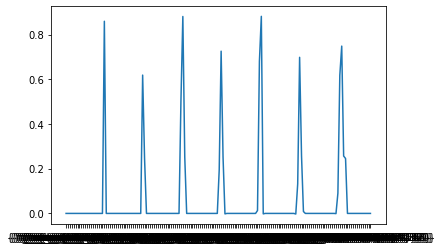

In [56]:
cow_data = np.array(cow_features)[:,:,0,0]

pca_ncomps = [1, 2, 3, 4, 5, 6, 10, 20]#, 25, 30, 35, 40, 50, 75, 100, 125, 150]
# pca_ncomps = list(range(25, 36))
# n_eps = np.array(range(1, 500, 4)) / 100
n_eps = np.array(range(1, 21))
nsamples = [2]
dbscan_elbows = []
hyperparameter_combos = []
for n_comps in pca_ncomps:
    for eps in n_eps:
        for samp in nsamples:
            # do PCA w n_comps components
            pca = PCA(n_components=n_comps, random_state=64)
            # Fit and transform your data to reduce it to 2 dimensions
            pca_result = pca.fit_transform(cow_data)

            # Perform DBSCAN clustering
            dbscan = DBSCAN(eps=eps, min_samples=samp)
            cluster_labs = dbscan.fit_predict(pca_result)

            # create df with image names, image dates (img names with 'img_' and file extension stripped, gt animal id, and clustering animal id
            clusters_and_gt = pd.DataFrame({'img_dates': img_dates, 'gt_animal_id': animal_id, 'kmeans_labs': dbscan.labels_})

            dbscan_elbows.append(metrics.adjusted_rand_score(dbscan.labels_, [str(i) for i in clusters_and_gt.gt_animal_id]))
            hyperparameter_combos.append({'n_comps': n_comps, 'eps': eps})
        
plt.plot([str(i) for i in hyperparameter_combos], dbscan_elbows)

In [42]:
np.array(hyperparameter_combos)[dbscan_elbows == max(dbscan_elbows)]  # max(dbscan_elbows) = .646367

array([{'n_comps': 6, 'eps': 3}], dtype=object)

In [44]:
max(dbscan_elbows)

0.8812380764490034

### DBSCAN with t-SNE

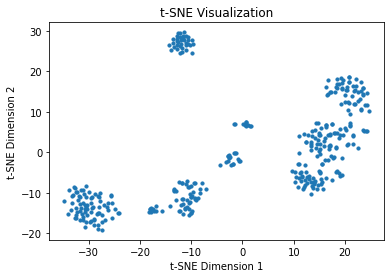

In [46]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(cow_data)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10)  # s controls point size
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

In [49]:
db = DBSCAN(eps=10, min_samples=2)  # You can adjust 'eps' and 'min_samples' as needed
cluster_labels = db.fit_predict(tsne_result)
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,

In [50]:
# from sklearn.metrics import 
metrics.adjusted_rand_score(cluster_labels, [str(i) for i in clusters_and_gt.gt_animal_id])

0.25222603687956896

In [ ]:
dawg = ['nan', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'nan',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05', 'AN-05',
       'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02',
       'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02',
       'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02',
       'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02',
       'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'AN-02', 'nan',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'nan', 'AN-06', 'AN-06', 'AN-06',
       'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06', 'AN-06']

#### HDBSCAN
Not going to work because of version issues ://
I have Python 3.6.8 and HDBSCAN was not part of that version

In [ ]:
# from sklearn.cluster import HDBSCAN
# pca_ncomps = [2]#, 3, 4, 5, 6, 10, 20, 25, 30, 35, 40, 50, 75, 100, 125, 150]
# # pca_ncomps = list(range(25, 36))
# min_clust_sizes = [3, 5, 8]
# clust_eps = [.1, .2]

# hdbscan_elbows = []
# hyperparameter_combos = []
# for n_comps in pca_ncomps:
#     for minc in min_clust_sizes:
#         for cse in clust_eps:
#             # do PCA w n_comps components
#             pca = PCA(n_components=n_comps, random_state=64)
#             # Fit and transform your data to reduce it to 2 dimensions
#             pca_result = pca.fit_transform(cow_data)

#             # Perform DBSCAN clustering
#             hdbscan = HDBSCAN(min_cluster_size=minc, cluster_selection_epsilon=cse)
#             cluster_labs = hdbscan.fit_predict(pca_result)

#             # create df with image names, image dates (img names with 'img_' and file extension stripped, gt animal id, and clustering animal id
#             clusters_and_gt = pd.DataFrame({'img_dates': img_dates, 'gt_animal_id': animal_id, 'kmeans_labs': hdbscan.labels_})

#             hdbscan_elbows.append(metrics.adjusted_rand_score(hdbscan.labels_, [str(i) for i in clusters_and_gt.gt_animal_id]))
#             hyperparameter_combos.append({'n_comps': n_comps, 'minc': minc, 'eps': cse})
        
# plt.plot([str(i) for i in hyperparameter_combos], hdbscan_elbows)

ImportError: cannot import name 'HDBSCAN'

#### Affinity Propagation

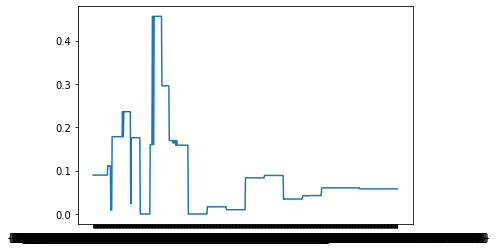

In [ ]:
from sklearn.cluster import AffinityPropagation
pca_ncomps = [2, 3, 4, 5, 6, 10, 20, 25, 30, 35, 40, 50, 75, 100, 125, 150]
damps = np.array(range(9580, 9800, 5)) / 10000
ap_elbows = []
hyperparameter_combos = []
for n_comps in pca_ncomps:
    for damp in damps:
        # do PCA w n_comps components
        pca = PCA(n_components=n_comps, random_state=64)
        # Fit and transform your data to reduce it to 2 dimensions
        pca_result = pca.fit_transform(cow_data)

        # Perform DBSCAN clustering
        ap = AffinityPropagation(damping=damp, random_state=64)
        cluster_labs = ap.fit_predict(pca_result)
        
        # create df with image names, image dates (img names with 'img_' and file extension stripped, gt animal id, and clustering animal id
        clusters_and_gt = pd.DataFrame({'img_dates': img_dates, 'gt_animal_id': animal_id, 'kmeans_labs': ap.labels_})
        
        ap_elbows.append(metrics.adjusted_rand_score(ap.labels_, [str(i) for i in clusters_and_gt.gt_animal_id]))
        hyperparameter_combos.append({'n_comps': n_comps, 'damping': damp})
        
plt.plot([str(i) for i in hyperparameter_combos], ap_elbows)

In [ ]:
np.array(hyperparameter_combos)[ap_elbows == max(ap_elbows)]  # max(dbscan_elbows) = .646367

array([{'n_comps': 5, 'damping': 0.9605},
       {'n_comps': 5, 'damping': 0.961},
       {'n_comps': 5, 'damping': 0.9625},
       {'n_comps': 5, 'damping': 0.963},
       {'n_comps': 5, 'damping': 0.9635},
       {'n_comps': 5, 'damping': 0.964},
       {'n_comps': 5, 'damping': 0.9645},
       {'n_comps': 5, 'damping': 0.965},
       {'n_comps': 5, 'damping': 0.9655},
       {'n_comps': 5, 'damping': 0.966},
       {'n_comps': 5, 'damping': 0.9665},
       {'n_comps': 5, 'damping': 0.967},
       {'n_comps': 5, 'damping': 0.9675},
       {'n_comps': 5, 'damping': 0.968},
       {'n_comps': 5, 'damping': 0.9685},
       {'n_comps': 5, 'damping': 0.969},
       {'n_comps': 5, 'damping': 0.9695}, {'n_comps': 5, 'damping': 0.97},
       {'n_comps': 5, 'damping': 0.9705},
       {'n_comps': 5, 'damping': 0.971}], dtype=object)

In [ ]:
max(ap_elbows)

0.45636778704664044

#### Agglomerative Clustering

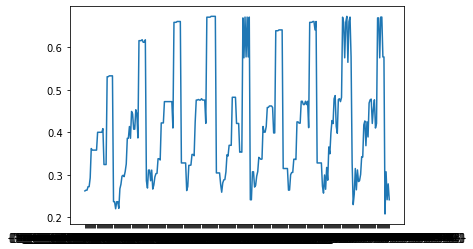

In [51]:
from sklearn.cluster import AgglomerativeClustering
# pca_ncomps = [2, 3, 4, 5, 6, 10, 20, 25, 30, 35, 40]#, 50, 75, 100, 125, 150]
pca_ncomps = list(range(25, 42, 2))
distances = np.array(range(12, 44))
ac_elbows = []
hyperparameter_combos = []
for n_comps in pca_ncomps:
    for dist in distances:
        # do PCA w n_comps components
        pca = PCA(n_components=n_comps)
        # Fit and transform your data to reduce it to 2 dimensions
        pca_result = pca.fit_transform(cow_data)

        # Perform DBSCAN clustering
        ac = AgglomerativeClustering(n_clusters=None, distance_threshold=dist)
        cluster_labs = ac.fit_predict(pca_result)
        
        # create df with image names, image dates (img names with 'img_' and file extension stripped, gt animal id, and clustering animal id
        clusters_and_gt = pd.DataFrame({'img_dates': img_dates, 'gt_animal_id': animal_id, 'kmeans_labs': ac.labels_})
        
        ac_elbows.append(metrics.adjusted_rand_score(ac.labels_, [str(i) for i in clusters_and_gt.gt_animal_id]))
        hyperparameter_combos.append({'n_comps': n_comps, 'distance': dist})
        
plt.plot([str(i) for i in hyperparameter_combos], ac_elbows)

In [52]:
print(np.array(hyperparameter_combos)[ac_elbows == max(ac_elbows)])
print(max(ac_elbows))

[{'n_comps': 31, 'distance': 35} {'n_comps': 31, 'distance': 36}
 {'n_comps': 31, 'distance': 37} {'n_comps': 31, 'distance': 38}
 {'n_comps': 31, 'distance': 39} {'n_comps': 39, 'distance': 35}]
0.6734232306442098


#### Feature Agglomeration

In [58]:
from sklearn.cluster import FeatureAgglomeration
fa = FeatureAgglomeration()
fa.fit(cow_data)
fa.transform(cow_data)
# pca_ncomps = [2, 3, 4, 5, 6, 10, 20, 25, 30, 35, 40]#, 50, 75, 100, 125, 150]
# distances = np.array(range(2, 35))
# ac_elbows = []
# hyperparameter_combos = []
# for n_comps in pca_ncomps:
#     for dist in distances:
#         # do PCA w n_comps components
#         pca = PCA(n_components=n_comps)
#         # Fit and transform your data to reduce it to 2 dimensions
#         pca_result = pca.fit_transform(cow_data)

#         # Perform DBSCAN clustering
#         ac = AgglomerativeClustering(n_clusters=None, distance_threshold=dist)
#         cluster_labs = ac.fit_predict(pca_result)
        
#         # create df with image names, image dates (img names with 'img_' and file extension stripped, gt animal id, and clustering animal id
#         clusters_and_gt = pd.DataFrame({'img_dates': img_dates, 'gt_animal_id': animal_id, 'kmeans_labs': ac.labels_})
        
#         ac_elbows.append(metrics.adjusted_rand_score(ac.labels_, [str(i) for i in clusters_and_gt.gt_animal_id]))
#         hyperparameter_combos.append({'n_comps': n_comps, 'distance': dist})
        
# plt.plot([str(i) for i in hyperparameter_combos], ac_elbows)

(377, 2)

#### *The code below is deprecated*

## Matching up w the ground truth
1. figure out which rows in the `gt` dataset are relevant to keep (reference "Notebook and best_model" email to yalong from late oct/early nov for where the gaps are)
    <br> a. make sure that it matches up on a second-by-second level, or come as close as u can to that
2. drop rows that you don't need
3. make sure that the pca clustering (cow_present = y/n) actually matches up to the "with_cows" dataset (?)
4. cluster the cows in the cow_present = y cluster and see if you can match that up w Egleu's ground truth (i think)

##### video times:
103225-103725  <br> 
103725-104225  <br>
104225-104725  <br>
104725-105225  <br>
110227-110727  <br>
110727-111227  <br>
111727-112227  <br>
112227-112727

In [37]:
gt = pd.read_csv('OUT_SENS_EDITED_2023-08-22_OUTPUT_SENSORSEDITED_FULLDAY_SENSORS - 1032 to1127h - OUT_SENS_EDITED_2023-08-22_OUTP.csv')
gt.head(4)

,DateTime,Date,Time,DT_001,DT_002,DT_003,DT_004,DT_005,DT_006,MN_001,...,FBK_02_VISIT,FBK_02_ANIMAL,FBK_03_VISIT,FBK_03_ANIMAL,FBK_04_VISIT,FBK_04_ANIMAL,FBK_05_VISIT,FBK_05_ANIMAL,FBK_06_VISIT,FBK_06_ANIMAL
0,2023-08-22 10:32:00,2023-08-22,10:32:00,30.10,25.31,36.51,24.88,25.40,29.21,1.0,...,0.0,NaN,0,NaN,0,NaN,0.0,NaN,0.0,NaN
1,2023-08-22 10:32:01,2023-08-22,10:32:01,33.99,30.07,36.51,24.88,26.27,29.71,1.0,...,0.0,NaN,0,NaN,0,NaN,0.0,NaN,0.0,NaN
2,2023-08-22 10:32:02,2023-08-22,10:32:02,30.10,26.17,36.51,24.88,30.21,29.73,1.0,...,0.0,NaN,0,NaN,0,NaN,0.0,NaN,0.0,NaN
3,2023-08-22 10:32:03,2023-08-22,10:32:03,30.10,26.15,36.07,24.88,30.21,29.21,1.0,...,0.0,NaN,0,NaN,0,NaN,0.0,NaN,0.0,NaN


In [210]:
every_4th_index = []
for i in range(len(selected_indices)):
    if i % 4 == 0:
        every_4th_index.append(selected_indices[i])

In [211]:
gt_relevant = gt.iloc[every_4th_index,:]
# gt_relevant

In [212]:
gt_relevant.head(3)  # FBK_03_ANIMAL
# animal_present = [True if str(i) != 'nan' else False for i in gt_relevant['FBK_03_ANIMAL']]
animal_present = [1 if str(i) != 'nan' else 0 for i in gt_relevant['FBK_03_ANIMAL']]
animal_present2 = [i if str(i) != 'nan' else 'No Animal' for i in gt_relevant['FBK_03_ANIMAL']]

In [218]:
gt_all_labs

In [214]:
gt_relevant['FBK_03_ANIMAL']

25        NaN
29        NaN
33        NaN
37        NaN
41        NaN
        ...  
3307    AN-06
3311    AN-06
3315    AN-06
3319    AN-06
3323    AN-06
Name: FBK_03_ANIMAL, Length: 600, dtype: object

## Time to match up predictions with ground truth! -- DEPRECATED FROM HERE DOWN

In [39]:
presence_of_a_cow = kmpca[2].labels_  # 1 == yes, 0 == no (conveniently)
gt = pd.read_csv('2023-08-22_OUTPUT_SENSORS_EDITED-01_TRANSP-01.csv')
gt

,DateTime,Date,Time,DT_001,DT_002,DT_003,DT_004,DT_005,DT_006,MN_001,...,FBK_02_VISIT,FBK_02_ANIMAL,FBK_03_VISIT,FBK_03_ANIMAL,FBK_04_VISIT,FBK_04_ANIMAL,FBK_05_VISIT,FBK_05_ANIMAL,FBK_06_VISIT,FBK_06_ANIMAL
0,2023-08-22 00:00:00,2023-08-22,00:00:00,29.86,25.02,29.62,24.57,25.14,30.26,1.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
1,2023-08-22 00:00:01,2023-08-22,00:00:01,29.86,25.03,29.60,24.60,25.12,30.26,1.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
2,2023-08-22 00:00:02,2023-08-22,00:00:02,29.86,25.02,29.62,24.59,25.12,30.24,1.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
3,2023-08-22 00:00:03,2023-08-22,00:00:03,29.85,25.02,29.60,24.59,25.14,28.93,1.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
4,2023-08-22 00:00:04,2023-08-22,00:00:04,29.86,25.02,29.60,24.59,25.14,28.92,1.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2023-08-22 23:59:55,2023-08-22,23:59:55,29.88,26.77,38.16,30.31,29.98,24.30,1.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
86396,2023-08-22 23:59:56,2023-08-22,23:59:56,29.88,36.27,38.16,30.29,29.98,24.30,1.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
86397,2023-08-22 23:59:57,2023-08-22,23:59:57,29.88,36.27,38.16,29.48,29.98,24.30,1.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
86398,2023-08-22 23:59:58,2023-08-22,23:59:58,29.88,36.29,29.62,30.31,30.00,24.30,1.0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [40]:
import math
def get_duration(filename):
    # import cv2
    video = cv2.VideoCapture(filename)

    # duration = video.get(cv2.CAP_PROP_POS_MSEC)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    # fps = math.ceil(video.get(cv2.CAP_PROP_FPS))
    # duration = math.ceil(frame_count / fps)
    fps = video.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps
    cv2.destroyAllWindows()
    return duration, frame_count
movie_paths = [os.path.join(video_source_folder, bro) for bro in os.listdir(os.path.join('/scratch/user/jwooley/plf', video_source_folder)) if bro[-4:] == '.mp4']
durations = [get_duration(movie) for movie in movie_paths]

In [41]:
sum([i[0] for i in durations])

2410.864

In [42]:
import os
import re
start_stop = []
for i in os.listdir('20230920_videos/20230920-Dataset Bunk 3 videos'):
    if i[-4:] == '.mp4':
        comps = re.split('-|_', i)
        start_hr = comps[1][0:2]
        start_min = comps[1][2:4]
        start_sec = comps[1][4:6]
        start_time = f'{start_hr}:{start_min}:{start_sec}'
        # start_time = datetime.time(start_hr, start_min, start_sec)
        
        end_hr = comps[2][0:2]
        end_min = comps[2][2:4]
        end_sec = comps[2][4:6]
        end_time = f'{end_hr}:{end_min}:{end_sec}'
        start_stop.append((start_time,end_time))
start_stop.sort()
start_stop

[('10:32:25', '10:37:25'),
 ('10:37:25', '10:42:25'),
 ('10:42:25', '10:47:25'),
 ('10:47:25', '10:52:25'),
 ('11:02:27', '11:07:27'),
 ('11:07:27', '11:12:27'),
 ('11:17:27', '11:22:27'),
 ('11:22:27', '11:27:27')]

In [43]:
is_there_a_cow = np.array([])
date_and_time = np.array([])
for window in start_stop:
    start = window[0]
    end = window[1]
    is_there_a_cow = np.concatenate((is_there_a_cow, np.array(gt.FBK_03_VISIT[(gt.Time >= start) & (gt.Time <= end)])))
    date_and_time = np.concatenate((date_and_time, np.array(gt.DateTime[(gt.Time >= start) & (gt.Time <= end)])))
    
gt_and_time = pd.DataFrame({'cow_there_gt': is_there_a_cow, 'timestamp': date_and_time})

In [44]:
gt_and_time.shape  # brooooo ok so the shape doesn't match ://///// that's dumb. it's only off by 4 though so that means it's gotta be close lol. i think it's a weird rounding error or something.
# maybe i need to use needleman-wunsch algo or something here to align it well?? idk

(2408, 2)

In [45]:
gt_and_time['kmeans_labels'] = kmpca[2].labels_[4:gt_and_time.shape[0]+4]

In [46]:
sum(gt_and_time.cow_there_gt)# == gt_and_time.kmeans_labels)
# sum(gt_and_time.kmeans_labels)

1419.0

In [48]:
## Needleman-Wunsch algorithm implementation
def needleman_wunsch(x, y, match, mu, delta):
    """Align two sequences with specified match/insertion/mismatch penalties.
    
    x: first sequence to match
    y: second sequence to match
    match: reward for matching
    mu: mismatch penalty
    delta: insertion penalty
    """
    table = np.zeros((len(x)+1, len(y)+1))

    # update outer row and column
    for i in range(1, len(x)+1):
        table[i, 0] = -i * delta
    for j in range(1, len(y)+1):
        table[0, j] = -j * delta
    # down to here works fine

    for i in range(1, len(x)+1):
        for j in range(1, len(y)+1):
            if x[i-1] == y[j-1]:
                # calculate scores/distances
                northwest = table[i-1, j-1] + match
                north = table[i-1, j] - delta
                west = table[i, j-1] - delta
                update_with_this = max(northwest, north, west)
                table[i,j] = update_with_this


            elif x[i-1] != y[j-1]:
                # calculate scores/distances
                northwest = table[i-1, j-1] - match
                north = table[i-1, j] - delta
                west = table[i, j-1] - delta
                update_with_this = max(northwest, north, west)
                table[i,j] = update_with_this

    # compute path back up + optimal sequence
    x_seq = ''
    y_seq = ''
    index_x = len(x)
    index_y = len(y)
    while index_x > 0 or index_y  > 0:
        if (index_x > 0) and (table[index_x, index_y] == (table[index_x - 1, index_y] - delta)):
            x_seq = x[index_x - 1] + x_seq
            y_seq = '+' + y_seq
            index_x = index_x - 1
        elif (index_y > 0) and (table[index_x, index_y] == (table[index_x, index_y - 1] - delta)):
            x_seq = '+' + x_seq
            y_seq = y[index_y - 1] + y_seq
            index_y = index_y - 1
        else:
            x_seq = x[index_x - 1] + x_seq
            y_seq = y[index_y - 1] + y_seq
            index_x = index_x - 1
            index_y = index_y - 1
    
    return print(f'The aligned sequences are:\n{x_seq}\n{y_seq}')

In [52]:
gt_and_time

,cow_there_gt,timestamp,kmeans_labels
0,0.0,2023-08-22 10:32:25,0
1,0.0,2023-08-22 10:32:26,0
2,0.0,2023-08-22 10:32:27,1
3,0.0,2023-08-22 10:32:28,0
4,0.0,2023-08-22 10:32:29,1
...,...,...,...
2403,1.0,2023-08-22 11:27:23,1
2404,1.0,2023-08-22 11:27:24,0
2405,1.0,2023-08-22 11:27:25,1
2406,1.0,2023-08-22 11:27:26,1


In [54]:
match = 1
mu = 1
delta = 2
needleman_wunsch(gt_and_time.cow_there_gt, kmpca[2].labels_, match, mu, delta)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

## More stuff from Yalong

In [37]:
cluster_one_indices = np.where(cluster_labels == 0)[0]

NameError: name 'cluster_labels' is not defined

In [94]:
cluster_one_indices[0]

6

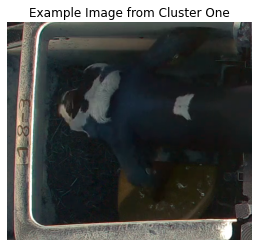

In [95]:
example_image = image_data[cluster_one_indices[50]]

# Display the example image
plt.imshow(example_image)
plt.title('Example Image from Cluster One')
plt.axis('off')  # Turn off axis labels
plt.show()

For the second round we do k-means clustering again. This time we try to differetiate different animals.

42
66
43
47
73
38
47
35
67
60


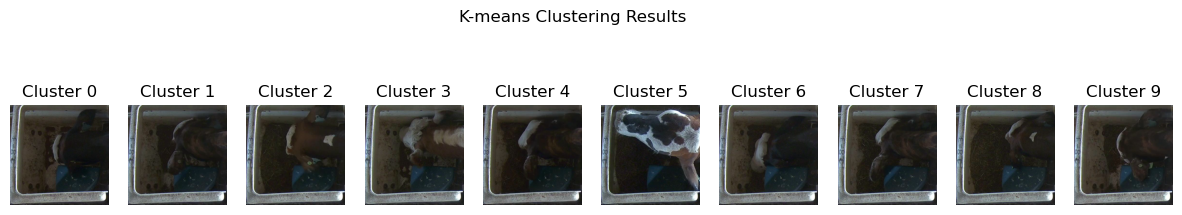

In [35]:
cluster_one=tsne_result[cluster_one_indices]
cluster_one_images=image_data[cluster_one_indices]

# Define the number of clusters (K)
num_clusters = 10  # Adjust this to your desired number of clusters

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(cluster_one)

# Create subplots to display images from each cluster
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 3))

for cluster_id in range(num_clusters):
    cluster_images = cluster_one_images[cluster_labels == cluster_id]
    print(len(cluster_images))
    # Choose a representative image from the cluster (e.g., the first one)
    sample_image = cluster_images[0]

    # Display the sample image
    axes[cluster_id].imshow(sample_image)
    axes[cluster_id].set_title(f'Cluster {cluster_id}')

for ax in axes:
    ax.axis('off')

plt.suptitle('K-means Clustering Results')
plt.show()


# DBSCAN

DBSCAN is a frequency based tool and that does not require us to set a fixed class number. This works for us because we do not know. We can test out all the eps distance parameters and apply that to all other images.

110
38
234
89
47


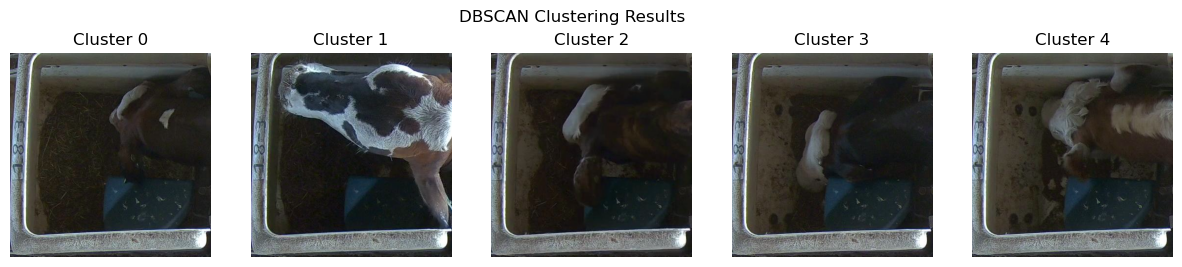

In [50]:
# Apply PCA to reduce the dimensionality (optional but can improve performance)
# pca = PCA(n_components=50)  # You can adjust the number of components as needed
# image_data_pca = pca.fit_transform(data)

# Perform DBSCAN clustering
db = DBSCAN(eps=5, min_samples=5)  # You can adjust 'eps' and 'min_samples' as needed
cluster_labels = db.fit_predict(cluster_one)

# Create subplots to display images from each cluster
unique_labels = np.unique(cluster_labels)
num_clusters = len(unique_labels)

fig, axes = plt.subplots(1, num_clusters, figsize=(15, 3))

for cluster_id, ax in zip(unique_labels, axes):
    cluster_images = cluster_one_images[cluster_labels == cluster_id]
    print(len(cluster_images))
    for i,img in enumerate(cluster_images):
        cv2.imwrite('DS1_clusters/Cluster'+str(cluster_id)+'_Number'+str(i)+'.jpg',img)
    # Choose a representative image from the cluster (e.g., the first one)
    if len(cluster_images) > 0:
        sample_image = cluster_images[0]

        # Display the sample image
        ax.imshow(sample_image)
        ax.set_title(f'Cluster {cluster_id}')
    else:
        ax.axis('off')
        ax.set_title(f'Cluster {cluster_id} (Empty)')

for ax in axes:
    ax.axis('off')

plt.suptitle('DBSCAN Clustering Results')
plt.show()

(904, 2048)

# Conclusion

The models suggests 5 different animals observed. Cluster 3 and 4 are well seperated but the rest is not clear. Using only the head shot images works to some degree but not all the time. Especially when animals head down to feed. The next step is use the full body. This requires MaskRCNN mask extraction first. The rest will follow the same steps as in this jupyter file.